In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/Dataset.csv')

df.head()

,Restaurant ID,Restaurant Name,Country Code,City,Address,Locality,Locality Verbose,Longitude,Latitude,Cuisines,...,Currency,Has Table booking,Has Online delivery,Is delivering now,Switch to order menu,Price range,Aggregate rating,Rating color,Rating text,Votes
0,6317637,Le Petit Souffle,162,Makati City,"Third Floor, Century City Mall, Kalayaan Avenu...","Century City Mall, Poblacion, Makati City","Century City Mall, Poblacion, Makati City, Mak...",121.027535,14.565443,"French, Japanese, Desserts",...,Botswana Pula(P),Yes,No,No,No,3,4.8,Dark Green,Excellent,314
1,6304287,Izakaya Kikufuji,162,Makati City,"Little Tokyo, 2277 Chino Roces Avenue, Legaspi...","Little Tokyo, Legaspi Village, Makati City","Little Tokyo, Legaspi Village, Makati City, Ma...",121.014101,14.553708,Japanese,...,Botswana Pula(P),Yes,No,No,No,3,4.5,Dark Green,Excellent,591
2,6300002,Heat - Edsa Shangri-La,162,Mandaluyong City,"Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...","Edsa Shangri-La, Ortigas, Mandaluyong City","Edsa Shangri-La, Ortigas, Mandaluyong City, Ma...",121.056831,14.581404,"Seafood, Asian, Filipino, Indian",...,Botswana Pula(P),Yes,No,No,No,4,4.4,Green,Very Good,270
3,6318506,Ooma,162,Mandaluyong City,"Third Floor, Mega Fashion Hall, SM Megamall, O...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.056475,14.585318,"Japanese, Sushi",...,Botswana Pula(P),No,No,No,No,4,4.9,Dark Green,Excellent,365
4,6314302,Sambo Kojin,162,Mandaluyong City,"Third Floor, Mega Atrium, SM Megamall, Ortigas...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.057508,14.584450,"Japanese, Korean",...,Botswana Pula(P),Yes,No,No,No,4,4.8,Dark Green,Excellent,229


In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

# Load the dataset
file_path = "Dataset.csv"  # Replace with your dataset file path
dataset = pd.read_csv(file_path)

# Step 1: Preprocessing the Dataset
# Select relevant columns
relevant_columns = ['Restaurant Name', 'City', 'Cuisines', 'Price range', 'Aggregate rating', 'Votes']
filtered_data = dataset[relevant_columns]

# Fill missing values in 'Cuisines' with 'Unknown'
filtered_data['Cuisines'] = filtered_data['Cuisines'].fillna('Unknown')

# Split multiple cuisines into lists for one-hot encoding
filtered_data['Cuisines'] = filtered_data['Cuisines'].apply(lambda x: x.split(', '))

# Step 2: Encoding Categorical Variables
# Apply one-hot encoding to the 'Cuisines' column
mlb = MultiLabelBinarizer()
cuisines_encoded = pd.DataFrame(mlb.fit_transform(filtered_data['Cuisines']),
                                 columns=mlb.classes_,
                                 index=filtered_data.index)

# Normalize numerical columns ('Aggregate rating' and 'Votes')
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(filtered_data[['Price range', 'Aggregate rating', 'Votes']])
scaled_features = pd.DataFrame(scaled_features, columns=['Price range', 'Aggregate rating', 'Votes'], index=filtered_data.index)

# Combine the encoded cuisines with the normalized dataset
preprocessed_data = pd.concat([filtered_data[['Restaurant Name', 'City']], scaled_features, cuisines_encoded], axis=1)

# Step 3: Content-Based Filtering
def recommend_restaurants(user_preferences, data, mlb, scaler, top_n=5):
    """
    Recommend restaurants based on user preferences.

    :param user_preferences: Dictionary containing user preferences
                              e.g., {'Cuisines': ['Japanese'], 'Price range': 3, 'Aggregate rating': 4.0}
    :param data: Preprocessed restaurant data
    :param mlb: MultiLabelBinarizer fitted on cuisines
    :param scaler: MinMaxScaler fitted on numeric features
    :param top_n: Number of recommendations to return
    :return: DataFrame of recommended restaurants
    """
    # Create a user preference vector
    user_vector = pd.DataFrame([user_preferences])
    user_vector[['Price range', 'Aggregate rating', 'Votes']] = scaler.transform(
        user_vector[['Price range', 'Aggregate rating', 'Votes']])

    # Handle one-hot encoding for cuisines
    user_cuisines = pd.DataFrame(mlb.transform([user_vector['Cuisines'][0]]),
                                 columns=mlb.classes_,
                                 index=user_vector.index)
    user_vector = pd.concat([user_vector.drop(columns=['Cuisines']), user_cuisines], axis=1).fillna(0)

    # Compute similarity scores
    similarity = cosine_similarity(user_vector, data.drop(columns=['Restaurant Name', 'City']))
    data['Similarity'] = similarity[0]

    # Return top N recommendations
    return data.nlargest(top_n, 'Similarity')[['Restaurant Name', 'City', 'Similarity']]

# Step 4: Testing the Recommendation System
# Example user preferences
user_preferences = {
    'Cuisines': ['Japanese'],
    'Price range': 3,
    'Aggregate rating': 4.0,
    'Votes': 100  # Add default vote preference
}

# Generate recommendations
recommendations = recommend_restaurants(user_preferences, preprocessed_data, mlb, scaler)
print(recommendations)


<ipython-input-3-5e1a6ffdf4e4>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Cuisines'] = filtered_data['Cuisines'].fillna('Unknown')
<ipython-input-3-5e1a6ffdf4e4>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Cuisines'] = filtered_data['Cuisines'].apply(lambda x: x.split(', '))


       Restaurant Name         City  Similarity
1466           Kuuraku      Gurgaon    0.999931
9289    3 Wise Monkeys      Jakarta    0.999573
1517          Daikichi      Gurgaon    0.998849
3809            Tamura    New Delhi    0.998166
1     Izakaya Kikufuji  Makati City    0.998010


Provide your preferences:
Enter your preferred city: Makati City
Enter your preferred cuisines (comma-separated): French, Japanese, Desserts
Enter your preferred price range (1-4): 3
Enter your preferred minimum rating (1.0-5.0): 4.0
Enter your preferred minimum votes: 123


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['desserts', 'french', 'japanese'] will be ignored
  warnings.warn(



Recommended Restaurants:
          Restaurant Name  Similarity
1        Izakaya Kikufuji    0.832712
0        Le Petit Souffle    0.664468
590   Carnival By Tresind    0.510410
4298       Masala Library    0.510407
9514     Ministry of Crab    0.510401


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['italian', 'mediterranean'] will be ignored
  warnings.warn(


Predicted scores: [0.70290615 0.70290453 0.70290348]
Actual scores: [0.53061224 0.57142857 0.67346939 0.65306122 0.6122449  0.59183673
 0.6122449  0.67346939 0.67346939 0.69387755 0.57142857 0.71428571
 0.65306122 0.59183673 0.6122449  0.59183673 0.67346939 0.6122449
 0.65306122 0.55102041 0.55102041 0.67346939 0.69387755 0.55102041
 0.57142857 0.6122449  0.65306122 0.59183673]

Mean Squared Error (Evaluation Metric): 0.01594582831074064


<ipython-input-53-e75f6d08ccbc>:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Price range', data=filtered_data, palette='coolwarm')


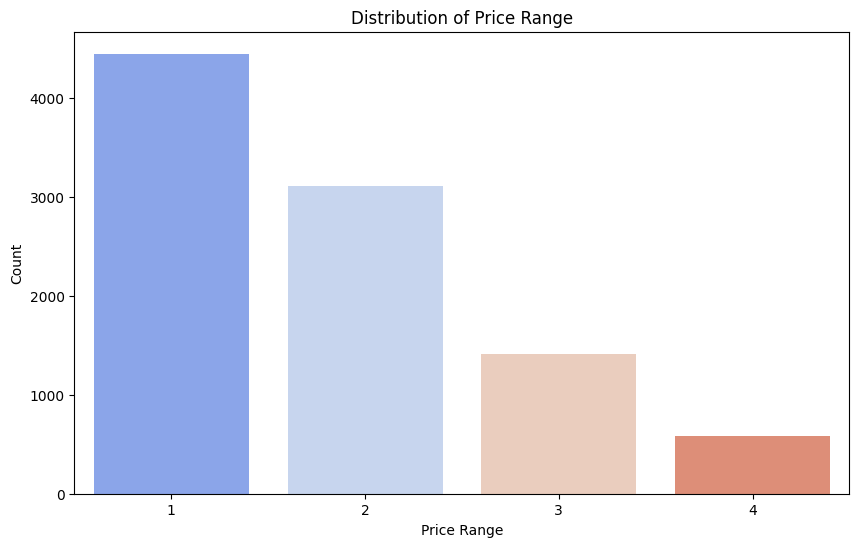

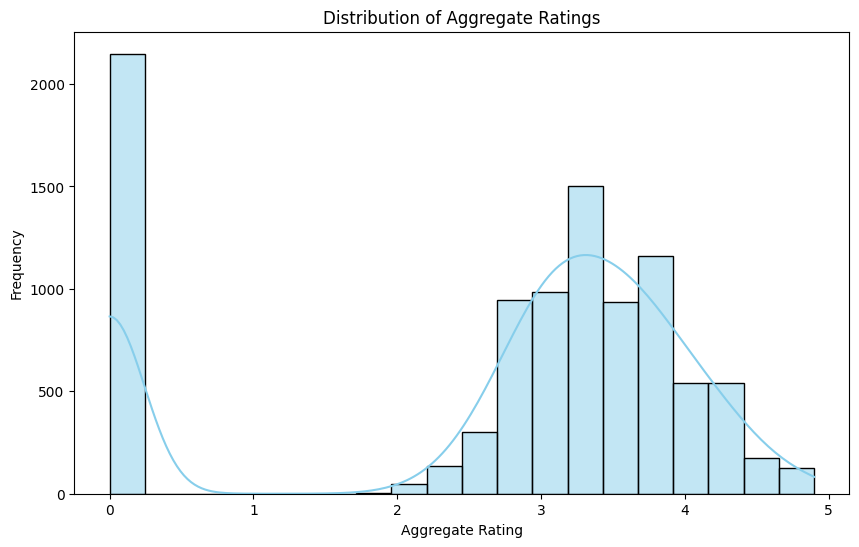

<ipython-input-53-e75f6d08ccbc>:171: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cuisines.index, y=top_cuisines.values, palette='viridis')


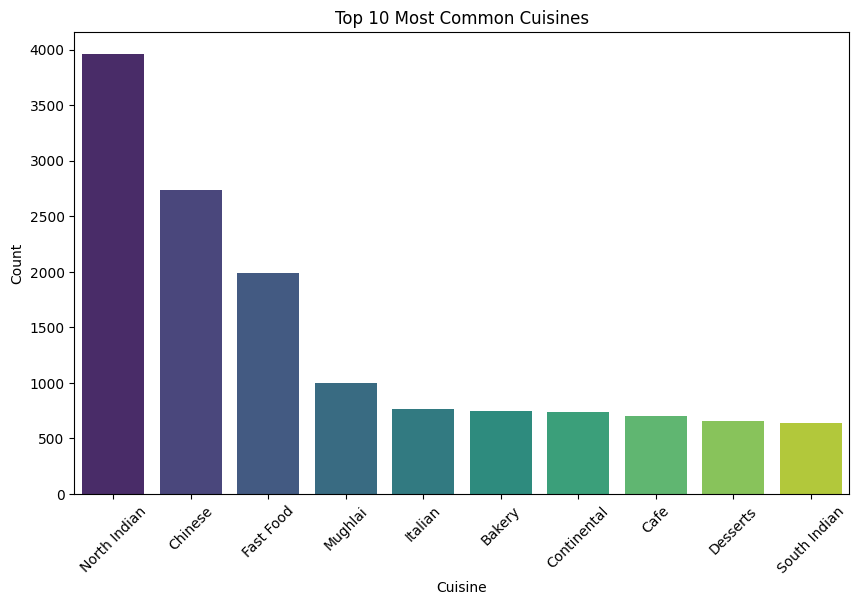

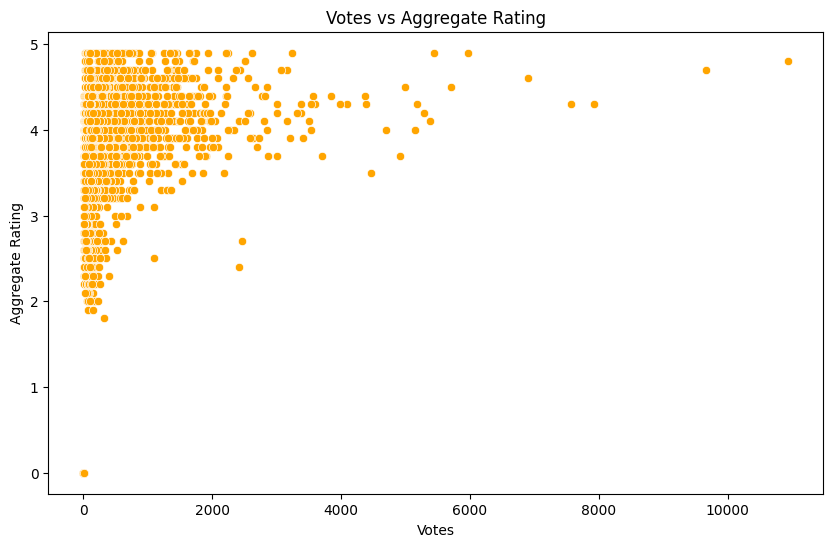

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['desserts', 'french', 'japanese'] will be ignored
  warnings.warn(


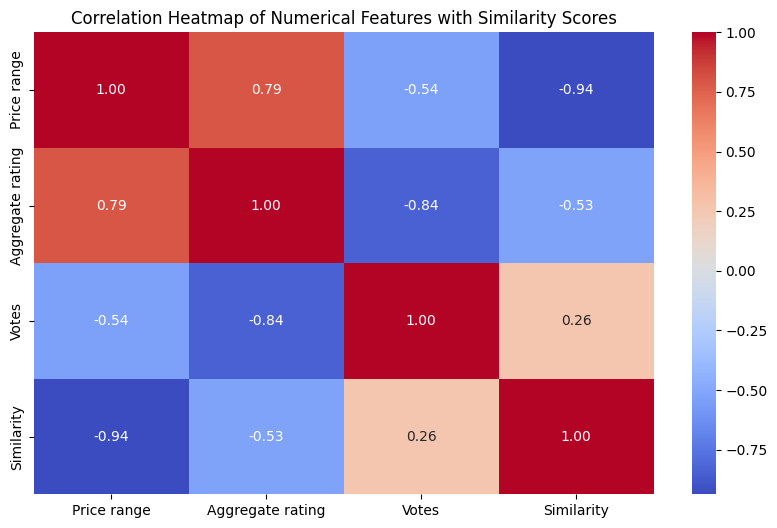

<ipython-input-53-e75f6d08ccbc>:215: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Similarity', y='Restaurant Name', data=recommendations.head(10), palette='coolwarm')


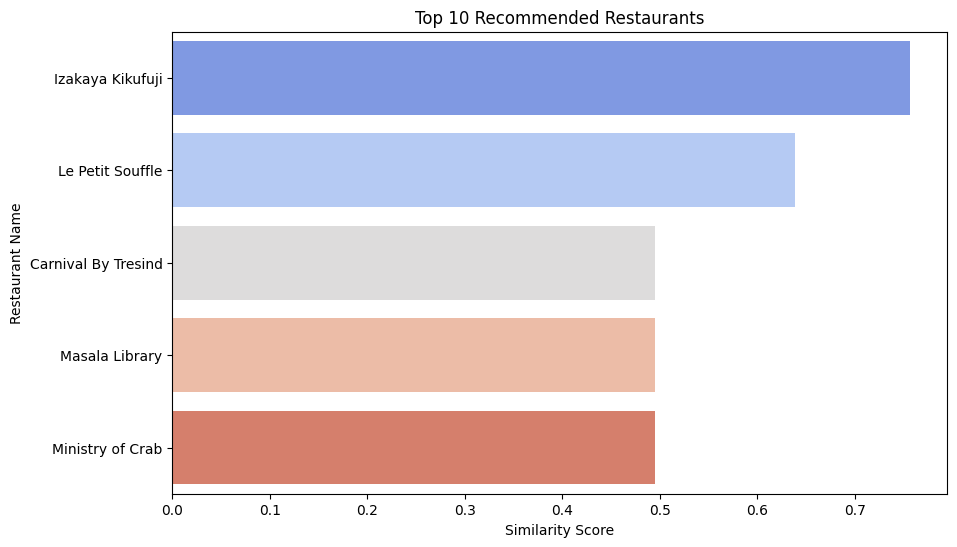

In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = "/content/Dataset.csv"  # Updated path to match uploaded file
dataset = pd.read_csv(file_path)

# Step 1: Preprocessing the Dataset
# Select relevant columns
relevant_columns = ['Restaurant Name', 'City', 'Cuisines', 'Price range', 'Aggregate rating', 'Votes']
filtered_data = dataset[relevant_columns].copy()

# Fill missing values in 'Cuisines' with 'Unknown'
filtered_data.loc[:, 'Cuisines'] = filtered_data['Cuisines'].fillna('Unknown')

# Split multiple cuisines into lists for one-hot encoding
filtered_data.loc[:, 'Cuisines'] = filtered_data['Cuisines'].apply(lambda x: x.split(', '))

# Apply one-hot encoding to 'City' and 'Cuisines'
mlb_cuisines = MultiLabelBinarizer()
cuisines_encoded = pd.DataFrame(mlb_cuisines.fit_transform(filtered_data['Cuisines']),
                                 columns=mlb_cuisines.classes_,
                                 index=filtered_data.index)

city_encoded = pd.get_dummies(filtered_data['City'], prefix='City')

# Normalize numerical columns ('Price range', 'Aggregate rating', 'Votes')
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(filtered_data[['Price range', 'Aggregate rating', 'Votes']])
scaled_features = pd.DataFrame(scaled_features, columns=['Price range', 'Aggregate rating', 'Votes'], index=filtered_data.index)

# Combine all processed features
preprocessed_data = pd.concat([filtered_data[['Restaurant Name', 'City']], city_encoded, cuisines_encoded, scaled_features], axis=1)

# Step 2: Content-Based Filtering (updated to handle case-insensitive inputs)
def recommend_restaurants(user_preferences, data, mlb_cuisines, scaler, top_n=5):
    """
    Recommend restaurants based on user preferences.
    """
    # Normalize cuisines to lowercase for matching
    user_preferences['Cuisines'] = [c.lower() for c in user_preferences['Cuisines']]

    # Create a user preference vector
    user_vector = pd.DataFrame([user_preferences])
    user_vector[['Price range', 'Aggregate rating', 'Votes']] = scaler.transform(
        user_vector[['Price range', 'Aggregate rating', 'Votes']])

    # Encode cuisines, handle unknown cuisines
    try:
        user_cuisines = pd.DataFrame(mlb_cuisines.transform([user_vector['Cuisines'][0]]),
                                     columns=mlb_cuisines.classes_,
                                     index=user_vector.index)
    except ValueError:
        # If no cuisines match, set all to zero
        user_cuisines = pd.DataFrame(0, columns=mlb_cuisines.classes_, index=user_vector.index)

    # Encode city
    user_city = pd.get_dummies(user_vector['City'], prefix='City')

    # Combine all user preferences
    user_vector = pd.concat([user_city, user_cuisines, user_vector[['Price range', 'Aggregate rating', 'Votes']]], axis=1).fillna(0)

    # Match feature columns
    user_vector = user_vector.reindex(columns=data.columns.drop(['Restaurant Name', 'City']), fill_value=0)

    # Compute similarity scores
    similarity = cosine_similarity(user_vector, data.drop(columns=['Restaurant Name', 'City']))
    data['Similarity'] = similarity[0]

    # Return top N recommendations
    return data.nlargest(top_n, 'Similarity')[['Restaurant Name', 'Similarity']]

# Step 3: Evaluate the System
def evaluate_system(data, mlb_cuisines, scaler):
    """
    Evaluate the recommendation system using Mean Squared Error.
    """
    # Split the data
    train, test = train_test_split(data, test_size=0.2, random_state=42)

    # Simulate user preferences from the test set
    simulated_user = test.sample(1)

    # Reconstruct cuisines from one-hot encoded columns
    cuisine_columns = mlb_cuisines.classes_
    user_cuisines = [
        cuisine for cuisine in cuisine_columns if simulated_user[cuisine].values[0] == 1
    ]

    simulated_preferences = {
        'City': simulated_user['City'].values[0],
        'Cuisines': user_cuisines,
        'Price range': simulated_user['Price range'].values[0],
        'Aggregate rating': simulated_user['Aggregate rating'].values[0],
        'Votes': simulated_user['Votes'].values[0]
    }

    # Get recommendations
    recommendations = recommend_restaurants(simulated_preferences, train, mlb_cuisines, scaler)

    # Filter recommendations to match the test set
    matching_restaurants = test[test['Restaurant Name'].isin(recommendations['Restaurant Name'])]
    predicted_scores = recommendations[recommendations['Restaurant Name'].isin(matching_restaurants['Restaurant Name'])]['Similarity'].values
    actual_scores = matching_restaurants['Aggregate rating'].values

    # Debugging output
    print(f"Predicted scores: {predicted_scores}")
    print(f"Actual scores: {actual_scores}")

    # Ensure lengths match before calculating MSE
    if len(predicted_scores) == 0 or len(actual_scores) == 0:
        print("No matches found for MSE calculation.")
        return float('inf')  # Return infinity if no matches are found

    # Adjust for unequal lengths (if any)
    min_length = min(len(predicted_scores), len(actual_scores))
    mse = mean_squared_error(actual_scores[:min_length], predicted_scores[:min_length])

    return mse

# Step 4: User Input and Testing
print("Provide your preferences:")
user_city = input("Enter your preferred city: ")
user_cuisines = input("Enter your preferred cuisines (comma-separated): ").split(', ')
user_price_range = int(input("Enter your preferred price range (1-4): "))
user_rating = float(input("Enter your preferred minimum rating (1.0-5.0): "))
user_votes = int(input("Enter your preferred minimum votes: "))

user_preferences = {
    'City': user_city,
    'Cuisines': [c.lower() for c in user_cuisines],
    'Price range': user_price_range,
    'Aggregate rating': user_rating,
    'Votes': user_votes
}

# Generate recommendations
recommendations = recommend_restaurants(user_preferences, preprocessed_data, mlb_cuisines, scaler)
print("\nRecommended Restaurants:")
print(recommendations)

# Evaluate the system
mse = evaluate_system(preprocessed_data, mlb_cuisines, scaler)
print(f"\nMean Squared Error (Evaluation Metric): {mse}")

# Visualization 1: Distribution of Price Range
plt.figure(figsize=(10, 6))
sns.countplot(x='Price range', data=filtered_data, palette='coolwarm')
plt.title('Distribution of Price Range')
plt.xlabel('Price Range')
plt.ylabel('Count')
plt.show()

# Visualization 2: Distribution of Aggregate Ratings
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['Aggregate rating'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Aggregate Ratings')
plt.xlabel('Aggregate Rating')
plt.ylabel('Frequency')
plt.show()

# Visualization 3: Top 10 Most Common Cuisines
top_cuisines = filtered_data['Cuisines'].explode().value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_cuisines.index, y=top_cuisines.values, palette='viridis')
plt.title('Top 10 Most Common Cuisines')
plt.xlabel('Cuisine')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Visualization 4: Votes vs. Aggregate Rating
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Votes', y='Aggregate rating', data=filtered_data, color='orange')
plt.title('Votes vs Aggregate Rating')
plt.xlabel('Votes')
plt.ylabel('Aggregate Rating')
plt.show()

# Step 5: Refine Correlation Analysis
user_preferences = {
    'City': user_city,
    'Cuisines': [c.lower() for c in user_cuisines],
    'Price range': user_price_range,
    'Aggregate rating': user_rating,
    'Votes': user_votes
}

# Generate recommendations
recommendations = recommend_restaurants(user_preferences, preprocessed_data, mlb_cuisines, scaler)

# Step 2: Merge the similarity scores with the numerical features of the recommended restaurants
recommended_data = preprocessed_data[preprocessed_data['Restaurant Name'].isin(recommendations['Restaurant Name'])]
recommended_data = recommended_data[['Restaurant Name', 'Price range', 'Aggregate rating', 'Votes']]
recommended_data['Similarity'] = recommendations['Similarity'].values

# Step 3: Compute the correlation matrix between numerical features and similarity scores
correlation_matrix = recommended_data[['Price range', 'Aggregate rating', 'Votes', 'Similarity']].corr()

# Step 4: Plotting the correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features with Similarity Scores')
plt.show()


# Visualization 6: Most Recommended Restaurants
plt.figure(figsize=(10, 6))
sns.barplot(x='Similarity', y='Restaurant Name', data=recommendations.head(10), palette='coolwarm')
plt.title('Top 10 Recommended Restaurants')
plt.xlabel('Similarity Score')
plt.ylabel('Restaurant Name')
plt.show()
